In [1]:
import qtensor
import matplotlib.pyplot as plt
from cartesian_explorer import Explorer

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
ex = Explorer()

In [4]:
@ex.provider
def classical_time_est(N, flops=1e9):
    flop_per_check = 1.5*N
    checks = 0.5*2**N
    nflop = flop_per_check*checks
    return nflop/flops
    
@ex.provider
def classical_energy_est(classical_time_est):
    computer_watts = 100
    return classical_time_est*computer_watts

In [373]:
@ex.provider
def quantum_time_est(N, p, gate_time=15e-6):
    gates_cnt = 2*p + p*(N+1.5*N)
    return gate_time*gates_cnt*10e3

@ex.provider
def quantum_energy_est(quantum_time_est):
    computer_watts = 10e3
    return quantum_time_est*computer_watts

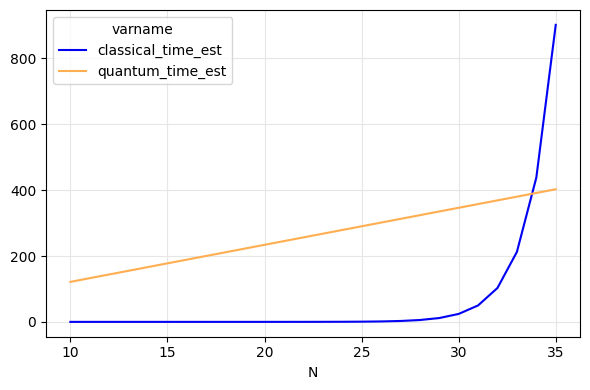

In [6]:
fig = ex.plot_variables(('classical_time_est', 'quantum_time_est')
                 , N=range(10, 36, 1)
                 , p=[30]
                 )

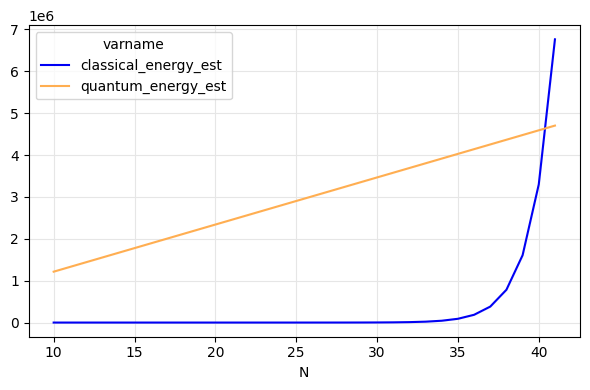

In [7]:
fig = ex.plot_variables(('classical_energy_est', 'quantum_energy_est')
                 , N=range(10, 42, 1)
                 , p=[30]
                 )

## Compare with Gurobi solver

In [7]:
import time

In [16]:
@ex.provider
def graph(N):
    return qtensor.toolbox.random_graph(nodes=N, seed=10, degree=3)

@ex.add_function(provides=('classical_time_gurobi', 'opt_cost'), requires=('graph', ))
def classical_time_gurobi(graph):
    start = time.time()
    c, sol = qtensor.tools.maxcut.gurobi_maxcut(graph, max_time=10*60)
    return time.time() - start, c
    
@ex.provider
def classical_time_gw(graph):
    start = time.time()
    c = qtensor.tools.maxcut.goemans_williamson.gw_cost(graph)
    return time.time() - start
    

In [41]:
@ex.provider
def classical_match_qaoa(opt_cost, graph, approx_ratio=0.937):
    start = time.time()
    c, sol = qtensor.tools.maxcut.gurobi_maxcut(graph, max_cost=opt_cost*approx_ratio)
    return time.time() - start

@ex.provider
def classical_match_qaoa_est(graph, approx_ratio=0.937):
    opt_cost = 1.3835*graph.number_of_nodes()
    start = time.time()
    c, sol = qtensor.tools.maxcut.gurobi_maxcut(graph, max_cost=opt_cost*approx_ratio)
    return time.time() - start

In [313]:
def log_linear_fit(x, y, x_ext):
    a = np.polyfit(x, np.log(y), deg=1)
    F = np.poly1d(a)
    ln = F(x_ext)
    return np.exp(ln)

def linear_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=1)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

def cubic_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=3)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

def octa_fit(x, y, x_ext):
    a = np.polyfit(x, y, deg=6)
    F = np.poly1d(a)
    ln = F(x_ext)
    return ln

In [141]:
from dataclasses import dataclass

@dataclass
class Line:
    x: np.array 
    y: np.array

@dataclass
class LineFit(Line):
    fit: np.array
    fit_x: np.array


In [359]:
def get_advantage(p=30, approx_ratio=0.937
                  , match_max_N=1150, opt_max_N=310
                  , gw_max_N=160
                  , match_step_N=24
                  , match_fit='log'
                  , max_N = 3000
                 ):
    x_ext = np.array(range(10, max_N, 36))

    x_opt = np.array(range(10, opt_max_N, 16))
    opt_time = ex.map_variable(('classical_time_gurobi')
                     , N=x_opt
                     )
    opt_ext = np.arange(10, 700, 16)
    opt_fit = log_linear_fit(x_opt, opt_time, opt_ext)

    x_match = np.array(range(10, match_max_N, match_step_N))
    match_time = ex.map_variable(('classical_match_qaoa_est')
                                 , N=x_match
                                 , approx_ratio=[approx_ratio]
                                )
    
    if match_fit=='log':
        match_fit = log_linear_fit(x_match, match_time, x_ext)
    else:
        match_fit = linear_fit(x_match, match_time, x_ext)
        match_fit -= min(match_fit)
        match_fit += min(match_time)
    
    match = LineFit(x=x_match, y=match_time, fit=match_fit, fit_x=x_ext)
    opt = LineFit(x=x_opt, y=opt_time, fit=opt_fit, fit_x=opt_ext)
    
    x_gw = np.array(range(10, gw_max_N, 18))
    gw_time = ex.map_variable(('classical_time_gw')
                     , N=x_gw
                     )
    x_ext = np.arange(10, 2400, 12)
    gw_fit = cubic_fit(x_gw, gw_time, x_ext)
    gw = LineFit(x=x_gw, y=gw_time, fit=gw_fit, fit_x=x_ext)

    x_ext = np.array(range(10, max_N, 36))
    qaoa_times = ex.map_variable(('quantum_time_est')
                     , N=x_ext
                     , p=[p]
                     )
    qaoa = Line(x=x_ext, y=qaoa_times)
    return qaoa, gw, opt, match
    

In [360]:
ex.use_svg()


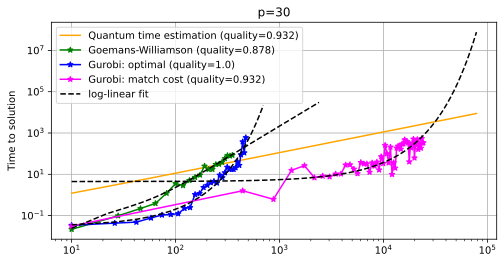

In [370]:
fig = plt.figure(figsize=(8, 4))

p=30
qaoa, gw, opt, match = get_advantage(p=p, approx_ratio=0.937
                                    , max_N=78500
                                    , opt_max_N=480
                                    , match_max_N=24500
                                    , match_step_N=72*6
                                    , match_fit='log'
                                    , gw_max_N=360
                                    )
plt.yscale('log')
plt.xscale('log')

plt.plot(qaoa.x, qaoa.y, color='orange', label='Quantum time estimation (quality=0.932)')
plt.plot(gw.x, gw.y, '*-', color='green', label='Goemans-Williamson (quality=0.878)')
plt.plot(opt.x, opt.y, '*-', color='blue', label='Gurobi: optimal (quality=1.0)')
plt.plot(match.x, match.y, '*-', color='magenta', label='Gurobi: match cost (quality=0.932)')
plt.plot(opt.fit_x, opt.fit, '--', color='black', label='log-linear fit')
plt.plot(match.fit_x, match.fit, '--', color='black')
plt.plot(gw.fit_x, gw.fit, '--', color='black')
plt.legend()
plt.ylabel('Time to solution')
plt.title(f'p={p}')
plt.grid()

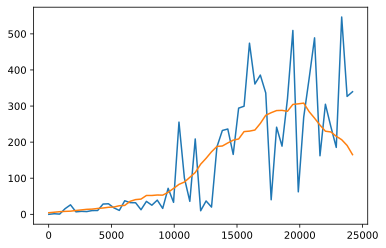

In [358]:
import scipy as sc
plt.plot(match.x, match.y)
plt.plot(match.x, sc.signal.convolve(match.y, np.ones(20)/20, mode='same'))

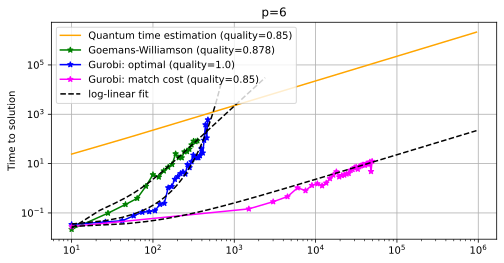

In [384]:
fig = plt.figure(figsize=(8, 4))

p=6
AR = qtensor.tools.BETHE_QAOA_VALUES['6']['val']
qaoa, gw, opt, match = get_advantage(p=p
                                     , approx_ratio=AR
                                     , match_max_N=50000
                                     , match_step_N=1500
                                     , max_N=950000
                                     , opt_max_N=480
                                     , gw_max_N=360
                                     , match_fit='lin'
                                    )
plt.yscale('log')
plt.xscale('log')

plt.plot(qaoa.x, qaoa.y, color='orange', label=f'Quantum time estimation (quality={np.round(AR, 3)})')
plt.plot(gw.x, gw.y, '*-', color='green', label='Goemans-Williamson (quality=0.878)')
plt.plot(opt.x, opt.y, '*-', color='blue', label='Gurobi: optimal (quality=1.0)')
plt.plot(match.x, match.y, '*-', color='magenta', label=f'Gurobi: match cost (quality={np.round(AR, 3)})')
plt.plot(opt.fit_x, opt.fit, '--', color='black', label='log-linear fit')
plt.plot(match.fit_x, match.fit, '--', color='black')
plt.plot(gw.fit_x, gw.fit, '--', color='black')
plt.legend(loc='upper left')
plt.ylabel('Time to solution')
plt.title(f'p={p}')
plt.grid()



Coefficients [ 1.38214286 -0.9547619 ]


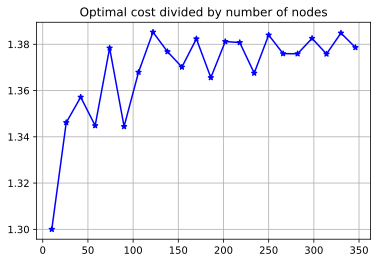

In [40]:
xs = range(10, 362, 16)
opt_data = ex.map_variable('opt_cost',
                  plot_kwargs=dict(marker='*'),
                  N=range(10, 362, 16))
plt.title('Optimal cost divided by number of nodes')
a = np.polyfit(xs[7:], opt_data[7:], deg=1)
x_ext = np.array(range(10, 1000, 16))
print('Coefficients', a)
F = np.poly1d(a)
#plt.plot(xs, opt_data, '*-', color='blue')
plt.plot(xs, opt_data/xs, '*-', color='blue')

plt.grid()

array([ 13.,  35.,  57.,  78., 102., 121., 145., 169., 190., 211., 235.,
       254., 279., 301., 320., 346., 366., 388., 412., 432., 457., 477.])